### diag_mode_contrib
What this notebook does:
* quantify the contribution of vertical modes on HKE
* surface or vertically integrated
* low-frequency or high-frequency component

This processes a single simulation at a single time.

In [5]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams['font.family'] = 'serif'

import numpy as np
import os, sys

import xarray as xr
from xgcm import Grid

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd
#sys.path.append('../../croco-si/tutorials/dev')
#import cswbib as bib

In [6]:
import crocosi.fast_interp3D

In [7]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8787')
client = Client(cluster)

import socket
host = socket.gethostname()
print("ssh -N -L {0}:{1}:{0} nlahaye@datarmor -f".format(
    cluster.dashboard_link.rstrip("/status").split(":")[-1], socket.gethostname())
     )

client

ssh -N -L 8787:r1i6n35:8787 nlahaye@datarmor -f


Client Scheduler: tcp://127.0.0.1:58755 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 100.00 GiB


# 1) Load data: simulation and vertical modes

In [8]:
root_path = '/home/datawork-lops-osi/equinox/jetn/' #'/home/c11-data/Test_aponte/jetn/' #

### pre-select run
it_amp = 1 
it_mod = 1 
pref = "" #"file_"
tid_str = "_m{0}a{1}".format(it_mod, it_amp)
run = "jet_cfg1_wp{0}{1}_{2}km_{3}a{4}j".format("{}", tid_str, 4, *(500, 1000))

### wrapper for loading run
def load_run(path, what="his", t_range=None, pref=pref, verb=False, grid_per=["xi"], **kwargs):
    r = pp.Run(path, prefix=pref, outputs=[what], verbose=verb, grid_periodicity=grid_per, 
               read_zarr=False, **kwargs)
    r[what] = r[what].assign_coords(time_index=r[what].time)\
        .swap_dims({"time":"time_instant"})\
        .rename({"time_instant":"time"})\
        .drop_vars("time_counter")
    r[what].time.attrs["units"] = "day"
    if t_range:
        ds = r[what].sel(time=slice(*t_range))
    else:
        ds = r[what]
    return r, ds

what = "his" # list of files to open


In [9]:
jet_wp = 7 # select run

r, ds = load_run(root_path+run.format(jet_wp), pref=pref, what=what, verb=True, grid_per=['xi'])
rho0 = r.params_input["rho0"]
gridcoords = {key:val.coords for key,val in r.xgrid.axes.items()}
xgrid = r.xgrid

# define path to mode. 
mode_path = root_path+run.format(jet_wp)+"/diagnostics/NL_vmodes/"
mode_file = "vmodes_mean-x_all-his.zarr"

ds

Analysing directory /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp7_m1a1_4km_500a1000j
Found 5 segments
Search for parameters in croco.in :
Parameters detected in output.mpi :
Opening datasets: grid / his
Grid size: (L ,M, N) = (258, 722, 50)


<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 50, time: 25, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates: (12/13)
  * y_rho                (y_rho) float32 -2e+03 2e+03 ... 2.878e+06 2.882e+06
  * x_rho                (x_rho) float32 -2e+03 2e+03 ... 1.022e+06 1.026e+06
  * s_rho                (s_rho) float32 -0.99 -0.97 -0.95 ... -0.05 -0.03 -0.01
    y_u                  (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_u                  (x_u) float32 0.0 4e+03 8e+03 ... 1.02e+06 1.024e+06
  * y_v                  (y_v) float32 0.0 4e+03 8e+03 ... 2.876e+06 2.88e+06
    ...                   ...
  * time                 (time) float64 520.0 540.0 560.0 ... 960.0 980.0 1e+03
    time_instant_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    f_rho                (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001265
    f                    (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001265
    time_index           (time) int64 0 1 2 3 4 5 6 7 ... 18 19 20 21 22 23 24
Dimensions without coordinates: axis_nbounds
Data variables: (12/21)
    ssh_a                (time, y_rho, x_rho) float32 dask.array<chunksize=(1, 722, 258), meta=np.ndarray>
    T_a                  (time, s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 50, 722, 258), meta=np.ndarray>
    u_a                  (time, s_rho, y_rho, x_u) float32 dask.array<chunksize=(1, 50, 722, 257), meta=np.ndarray>
    v_a                  (time, s_rho, y_v, x_rho) float32 dask.array<chunksize=(1, 50, 721, 258), meta=np.ndarray>
    w_a                  (time, s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 50, 722, 258), meta=np.ndarray>
    P_a                  (time, s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 50, 722, 258), meta=np.ndarray>
    ...                   ...
    w_t_sin              (time, s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 50, 722, 258), meta=np.ndarray>
    ssh_t_dirac          (time, y_rho, x_rho) float32 dask.array<chunksize=(1, 722, 258), meta=np.ndarray>
    T_t_dirac            (time, s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 50, 722, 258), meta=np.ndarray>
    u_t_dirac            (time, s_rho, y_rho, x_u) float32 dask.array<chunksize=(1, 50, 722, 257), meta=np.ndarray>
    v_t_dirac            (time, s_rho, y_v, x_rho) float32 dask.array<chunksize=(1, 50, 721, 258), meta=np.ndarray>
    w_t_dirac            (time, s_rho, y_rho, x_rho) float32 dask.array<chunksize=(1, 50, 722, 258), meta=np.ndarray>
Attributes:
    name:         his
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Oct-06 08:02:22 GMT
    uuid:         50294bcc-69b6-4633-9dc4-45174f442126

In [10]:
### load vertical modes
res = r.load_vmodes(mode_file.rstrip(".zarr"), directory=mode_path, persist=True)
if isinstance(res, tuple):
    vmodes = res[0]
else:
    vmodes = res
Nmodes = vmodes.ds.mode.size

/home1/datahome/zcaspar/croco/crocosi/vmodes.py:651: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  res = xr.apply_ufunc(compute_vmodes,


In [11]:
### select one time instant
it = 1
sds = ds.isel(time=it) # we will be working with this dataset from now on
vmodes.ds = vmodes.ds.isel(time=it)

# 2) Analysis
Project fields onto the vertical modes: e.g. $u_n = H^{-1}\int_{-H}^0 u(z) \phi_n(z) dz$. 

Using the method "project_puv" from Vmodes class

In [12]:
### project dynamics onto the modes

#compute 3D vertical grid
z_rho = r.get_z(zeta=sds.ssh_a, h=4e3 + sds.x_rho*sds.y_rho*0 , vgrid='r', hgrid='r').persist() # h should not be hard-coded

ds_p = xr.Dataset()
for v in "u_a", "u_t_cos", "u_t_sin":
    ds_p[v] = vmodes.project_puv(xgrid.interp(sds[v], "xi").chunk({"x_rho":-1}), z=z_rho)
for v in "v_a", "v_t_cos", "v_t_sin":
    ds_p[v] = vmodes.project_puv(xgrid.interp(sds[v], "eta",boundary='extrapolate').chunk({"y_rho":-1}), z=z_rho)
ds_p

<xarray.Dataset>
Dimensions:       (mode: 9, x_rho: 258, y_rho: 722)
Coordinates:
    f             (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001264 0.0001265
    f_rho         (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001264 0.0001265
    time_counter  float64 dask.array<chunksize=(), meta=np.ndarray>
    time_instant  float64 dask.array<chunksize=(), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.878e+06 2.882e+06
    y_u           (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.878e+06 2.882e+06
  * x_rho         (x_rho) float32 -2e+03 2e+03 6e+03 ... 1.022e+06 1.026e+06
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    time          float64 540.0
    time_index    int64 1
  * mode          (mode) int64 0 1 2 3 4 5 6 7 8
Data variables:
    u_a           (y_rho, x_rho, mode) float64 dask.array<chunksize=(722, 258, 9), meta=np.ndarray>
    u_t_cos       (y_rho, x_rho, mode) float64 dask.array<chunksize=(722, 258, 9), meta=np.ndarray>
    u_t_sin       (y_rho, x_rho, mode) float64 dask.array<chunksize=(722, 258, 9), meta=np.ndarray>
    v_a           (y_rho, x_rho, mode) float64 dask.array<chunksize=(722, 258, 9), meta=np.ndarray>
    v_t_cos       (y_rho, x_rho, mode) float64 dask.array<chunksize=(722, 258, 9), meta=np.ndarray>
    v_t_sin       (y_rho, x_rho, mode) float64 dask.array<chunksize=(722, 258, 9), meta=np.ndarray>

## Preliminary investigation: see what it looks like

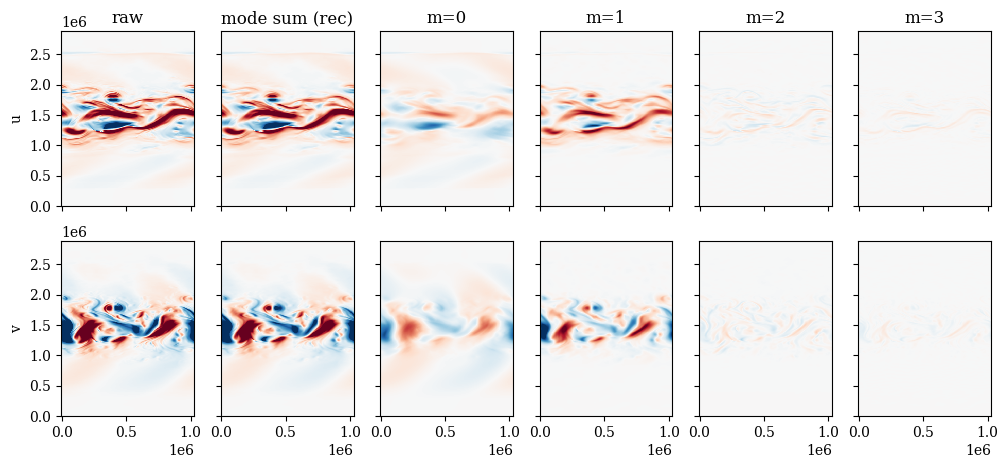

In [13]:
### surface currents: jet
n_mod_plot = 4
vamp = .5
norm = mpl.colors.Normalize(vmin=-vamp, vmax=vamp)

fig, axs = plt.subplots(2, n_mod_plot+2, figsize=(12,5), sharex=True, sharey=True)
for i,v in enumerate(["u", "v"]):
    ax = axs[i,0]
    sds[v+"_a"].isel(s_rho=-1).plot(ax=ax, norm=norm, add_colorbar=False)
    ax = axs[i,1]
    (ds_p[v+"_a"]*vmodes.ds.phi.isel(s_rho=-1)).sum("mode").plot(ax=ax, norm=norm, add_colorbar=False)
    for imod in range(n_mod_plot):
        ax = axs[i,imod+2]
        (ds_p[v+"_a"]*vmodes.ds.phi.isel(s_rho=-1)).isel(mode=imod).plot(ax=ax, norm=norm, add_colorbar=False)
    axs[i,0].set_ylabel(v)

for ax in axs.ravel():
    ax.set_title('')
    ax.set_xlabel('')
for ax in axs[:,1:].ravel():
    ax.set_ylabel('')
axs[0,0].set_title("raw")
axs[0,1].set_title("mode sum (rec)")
for imod in range(n_mod_plot):
    axs[0,2+imod].set_title("m="+str(imod))

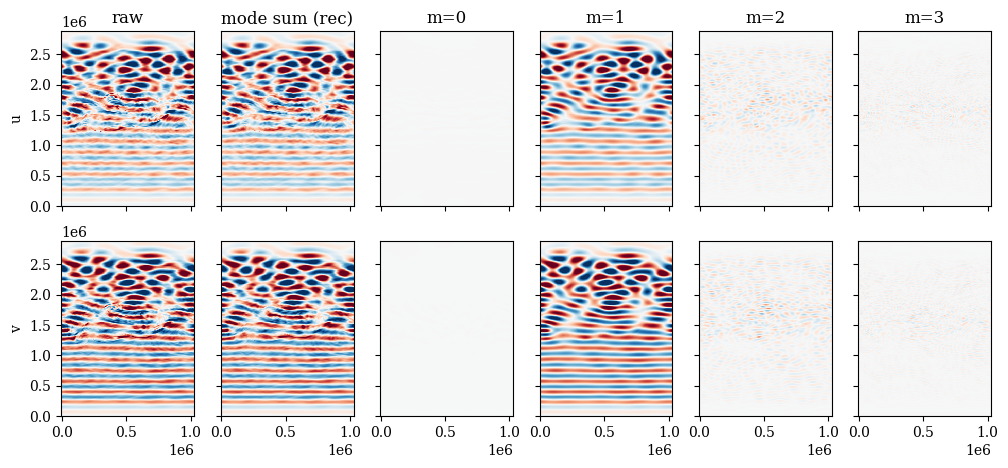

In [14]:
### surface currents: t_cos (IT)
n_mod_plot = 4
vamp = .1
norm = mpl.colors.Normalize(vmin=-vamp, vmax=vamp)

fig, axs = plt.subplots(2, n_mod_plot+2, figsize=(12,5), sharex=True, sharey=True)
for i,v in enumerate(["u", "v"]):
    ax = axs[i,0]
    sds[v+"_t_cos"].isel(s_rho=-1).plot(ax=ax, norm=norm, add_colorbar=False)
    ax = axs[i,1]
    (ds_p[v+"_t_cos"]*vmodes.ds.phi.isel(s_rho=-1)).sum("mode").plot(ax=ax, norm=norm, add_colorbar=False)
    for imod in range(n_mod_plot):
        ax = axs[i,imod+2]
        (ds_p[v+"_t_cos"]*vmodes.ds.phi.isel(s_rho=-1)).isel(mode=imod).plot(ax=ax, norm=norm, add_colorbar=False)
    axs[i,0].set_ylabel(v)

for ax in axs.ravel():
    ax.set_title('')
    ax.set_xlabel('')
for ax in axs[:,1:].ravel():
    ax.set_ylabel('')
axs[0,0].set_title("raw")
axs[0,1].set_title("mode sum (rec)")
for imod in range(n_mod_plot):
    axs[0,2+imod].set_title("m="+str(imod))

## contribution per mode on vertically integrated horizontal kinetic energy
Since velocity is decomposed as $u=\sum_n u_n \phi_n$, whith the orthonormality condition $\int \phi_n \phi_m dz = H \delta_{n,m}$, one has: $KE = \sum_n (u_n^2+v_n^2)/2$.

Several way to quantify the relative contribution of each mode. Here I take the relative contribution for the $x$-average

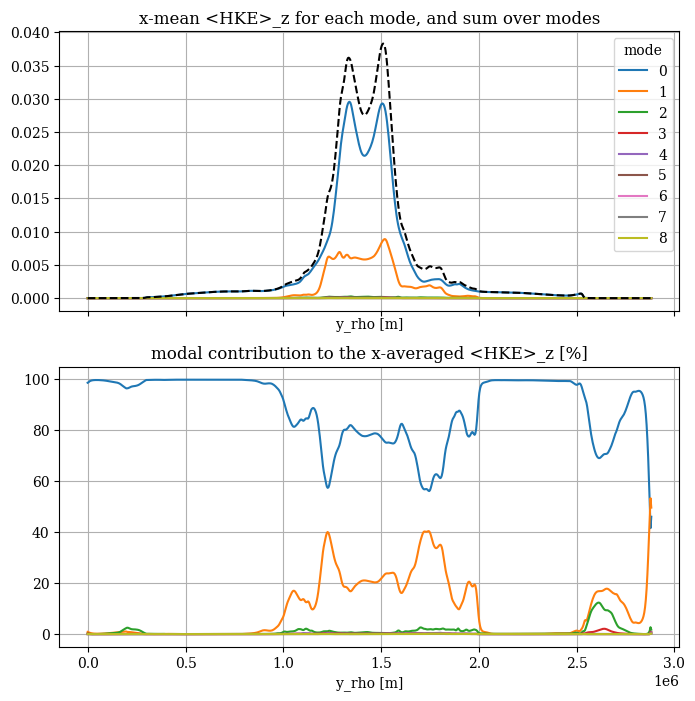

In [15]:
# mean vertically-averaged horizontal kinetic energy #
hke_vint = .5*(ds_p.u_a**2 + ds_p.v_a**2)
hke_vint_meanx = hke_vint.mean("x_rho")

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
ax = axs[0]
hke_vint_meanx.plot.line(x="y_rho", ax=ax)
hke_vint.sum("mode").mean("x_rho").plot(x="y_rho", color="k", linestyle="--", ax=ax)
ax.set_title("x-mean <HKE>_z for each mode, and sum over modes")

ax=axs[1]
(100*hke_vint_meanx/hke_vint_meanx.sum("mode")).plot.line(x="y_rho", ax=ax, add_legend=False)
ax.set_title("modal contribution to the x-averaged <HKE>_z [%]")

for ax in axs:
    ax.grid(True)


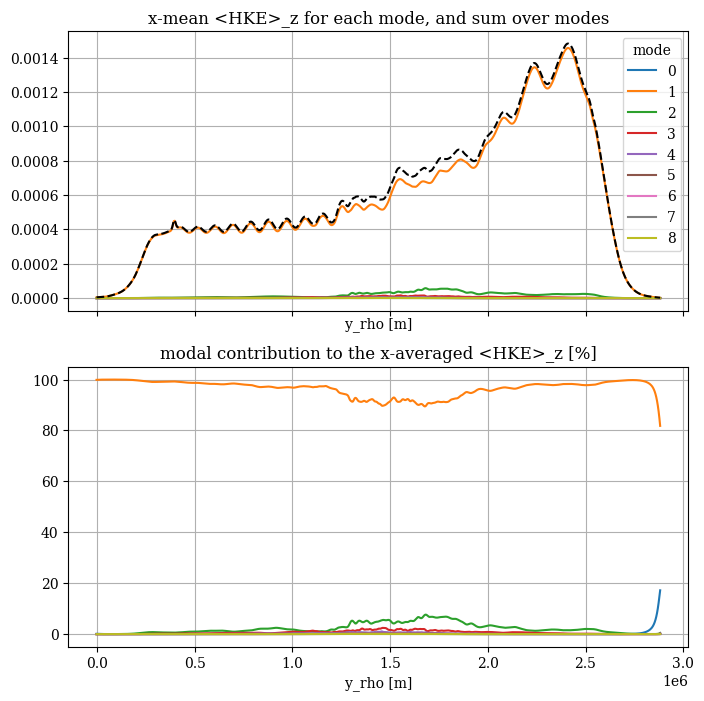

In [16]:
# IT vertically-averaged horizontal kinetic energy #
hke_vint = .5*(ds_p.u_t_cos**2 + ds_p.u_t_sin**2 + ds_p.v_t_cos**2 + ds_p.v_t_sin**2)
hke_vint_meanx = hke_vint.mean("x_rho")

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
ax = axs[0]
hke_vint_meanx.plot.line(x="y_rho", ax=ax)
hke_vint.sum("mode").mean("x_rho").plot(x="y_rho", color="k", linestyle="--", ax=ax)
ax.set_title("x-mean <HKE>_z for each mode, and sum over modes")

ax=axs[1]
(100*hke_vint_meanx/hke_vint_meanx.sum("mode")).plot.line(x="y_rho", ax=ax, add_legend=False)
ax.set_title("modal contribution to the x-averaged <HKE>_z [%]")

for ax in axs:
    ax.grid(True)

## surface field: diagnostic using variance reduction
for each mode, take 1 - HKE_all-modes-except-one/HKE_tot, on x averages.


In [19]:
### first: mean flow

sds["u_a_s"] = xgrid.interp(sds.u_a.isel(s_rho=-1), "xi")
sds["v_a_s"] = xgrid.interp(sds.v_a.isel(s_rho=-1), "eta",boundary='extend')
var_red = 1 - ( ( sds.u_a_s - ds_p.u_a*vmodes.ds.phi.isel(s_rho=-1) )**2 + 
            ( sds.v_a_s - ds_p.v_a*vmodes.ds.phi.isel(s_rho=-1) )**2
          ).mean("x_rho") / (sds.u_a_s**2 + sds.v_a_s**2).mean("x_rho")
var_red = var_red.persist()
var_red

<xarray.DataArray (y_rho: 722, mode: 9)>
dask.array<sub, shape=(722, 9), dtype=float64, chunksize=(720, 9), chunktype=numpy.ndarray>
Coordinates:
  * y_rho         (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.878e+06 2.882e+06
    y_u           (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.878e+06 2.882e+06
    time          float64 540.0
    f_rho         (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001264 0.0001265
    f             (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001264 0.0001265
    time_index    int64 1
    time_counter  float64 540.0
    time_instant  float64 540.0
  * mode          (mode) int64 0 1 2 3 4 5 6 7 8
    s_rho         float32 -0.01
    z_r           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>

Text(0.5, 1.0, 'Explained variance (HKE) at the surface: jet')

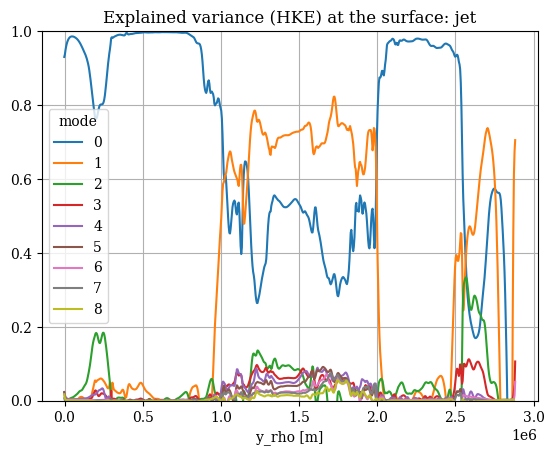

In [20]:
# plot it
var_red.plot.line(x="y_rho")
plt.gca().set_ylim([0, 1])
plt.grid(True)
plt.title("Explained variance (HKE) at the surface: jet")

In [23]:
### internal tide signal
for v in "t_cos", "t_sin":
    sds["u_"+v+"_s"] = xgrid.interp(sds["u_"+v].isel(s_rho=-1), "xi")
    sds["v_"+v+"_s"] = xgrid.interp(sds["v_"+v].isel(s_rho=-1), "eta",boundary='extend')
var_red = 1 - ( ( sds.u_t_cos_s - ds_p.u_t_cos*vmodes.ds.phi.isel(s_rho=-1) )**2 + 
                ( sds.u_t_sin_s - ds_p.u_t_sin*vmodes.ds.phi.isel(s_rho=-1) )**2 + 
                ( sds.v_t_cos_s - ds_p.v_t_cos*vmodes.ds.phi.isel(s_rho=-1) )**2 + 
                ( sds.v_t_sin_s - ds_p.v_t_sin*vmodes.ds.phi.isel(s_rho=-1) )**2 
          ).mean("x_rho") / \
        ( sds.u_t_cos_s**2 + sds.u_t_sin_s**2 + sds.v_t_cos_s**2 + sds.v_t_sin_s**2 ).mean("x_rho")
var_red = var_red.persist()
var_red

<xarray.DataArray (y_rho: 722, mode: 9)>
dask.array<sub, shape=(722, 9), dtype=float64, chunksize=(720, 9), chunktype=numpy.ndarray>
Coordinates:
  * y_rho         (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.878e+06 2.882e+06
    y_u           (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.878e+06 2.882e+06
    time          float64 540.0
    f_rho         (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001264 0.0001265
    f             (y_rho) float32 7.979e-05 7.985e-05 ... 0.0001264 0.0001265
    time_index    int64 1
    time_counter  float64 540.0
    time_instant  float64 540.0
  * mode          (mode) int64 0 1 2 3 4 5 6 7 8
    s_rho         float32 -0.01
    z_r           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>

Text(0.5, 1.0, 'Explained variance (HKE) at the surface: IT')

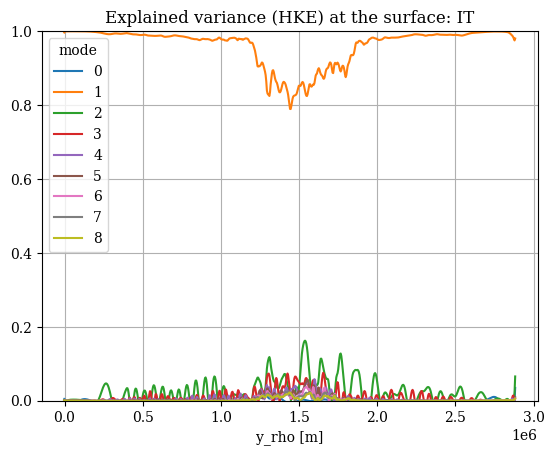

In [24]:
# plot it
var_red.plot.line(x="y_rho")
plt.gca().set_ylim([0, 1])
plt.grid(True)
plt.title("Explained variance (HKE) at the surface: IT")

In [25]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
